In [2]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import math

In [3]:
dataset_path = Path().resolve().parent/'dataset/HomeC.csv'
df = pd.read_csv(dataset_path)
dataset_path

C:\Users\ngxin\anaconda3\envs\time-series-labs\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


WindowsPath('C:/Users/ngxin/projects/Capstone-Project-Time-Series-Forecasting/dataset/HomeC.csv')

In [4]:
# clean data 
#remove kW
df.columns = [i.replace(' [kW]', '') for i in df.columns]
#combine similar objects
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#remove unused objects; icon and summary are objects that cannot be passed into calculation; use column same as House overall column and gen column same as Solar column
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary','Solar'],axis = 1,inplace = True)
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
#replace object in cloudCover with float
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
#set date time as index and drop time column
date_time = pd.date_range('2016-01-01 00:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [5]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability', 'Furnace', 'Kitchen'],
      dtype='object')

In [6]:
# Since the dataset has both energy and weather data, it is better we seperate them to do the resample method on them separately
# In this notebook, we are using use energy data only, so we are not doing any operation on the weather data
energy_data = df[['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen']]
energy_data

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,0.000967,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,0.000933,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,0.001000,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,0.000950,1.116033,0.000650


In [7]:
# aggregate the data in minutes into data in days 
data_per_hour = energy_data.resample("H").mean()
data_per_day = data_per_hour.resample("D").sum()
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405


<AxesSubplot:>

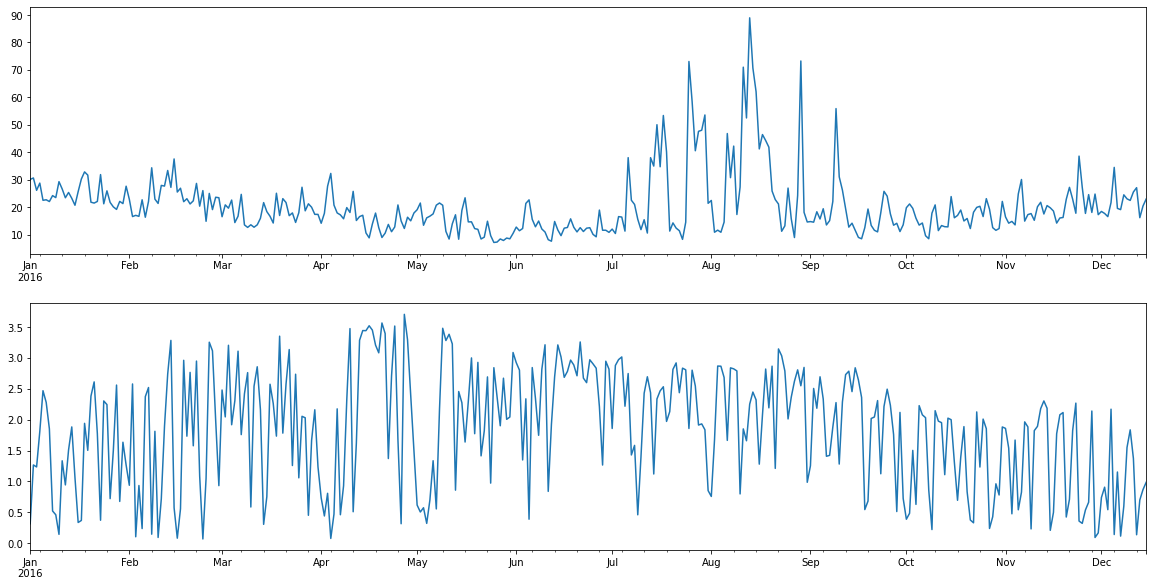

In [8]:
fig, axes = plt.subplots(nrows=2, ncols =1)
data_per_day["use"].plot(ax=axes[0],figsize = (20,10))
data_per_day["gen"].plot(ax=axes[1],figsize = (20,10))

# Naive Method

In [9]:
data_per_day["naive"] = data_per_day["use"].shift(1)
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen,naive
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536,NaN
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237,30.169358
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454,30.680708
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346,26.187171
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002,28.818997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857,22.519356
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664,25.590984
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495,27.150711
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405,16.241008


<AxesSubplot:>

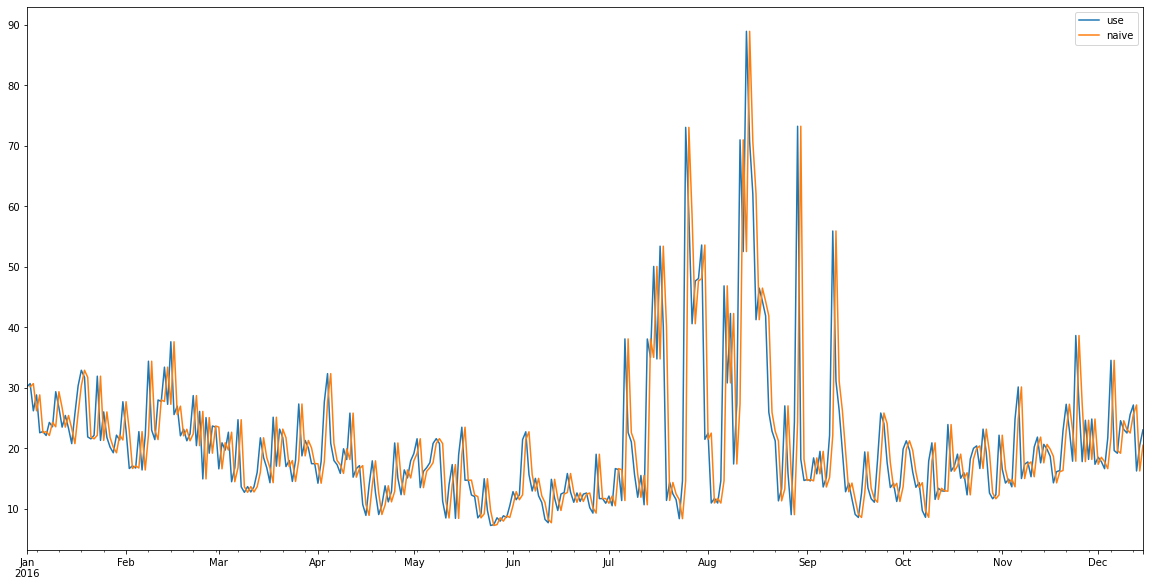

In [10]:
data_per_day[["use", "naive"]].plot(figsize=(20,10))

In [11]:
rmse_naive = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["naive"]]))
mape_naive = mean_absolute_percentage_error(data_per_day[-90:][["use"]], data_per_day[-90:][["naive"]])
print("The RMSE of naive forecast is: ", rmse_naive)
print("The MAPE of naive forecast is: ", mape_naive)

The RMSE of naive forecast is:  5.8613200805870145
The MAPE of naive forecast is:  0.23400608584027935


# Exponential Weighted Moving Average

In [12]:
# we use ewm function
data_per_day["ewma_2"] = data_per_day["use"].ewm(span = 2).mean()
data_per_day["ewma_2"] = data_per_day["ewma_2"].shift(1)
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen,naive,ewma_2
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536,NaN,NaN
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237,30.169358,30.169358
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454,30.680708,30.552871
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346,26.187171,27.530464
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002,28.818997,28.400223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857,22.519356,22.719500
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664,25.590984,24.633823
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495,27.150711,26.311748
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405,16.241008,19.597922


In [13]:
data_per_day["ewma_3"] = data_per_day["use"].ewm(span = 3).mean()
data_per_day["ewma_3"] = data_per_day["ewma_3"].shift(1)

In [14]:
data_per_day["ewma_7"] = data_per_day["use"].ewm(span = 7).mean()
data_per_day["ewma_7"] = data_per_day["ewma_7"].shift(1)

In [15]:
data_per_day["ewma_14"] = data_per_day["use"].ewm(span = 14).mean()
data_per_day["ewma_14"] = data_per_day["ewma_14"].shift(1)

In [16]:
data_per_day["ewma_30"] = data_per_day["use"].ewm(span = 30).mean()
data_per_day["ewma_30"] = data_per_day["ewma_30"].shift(1)

<AxesSubplot:>

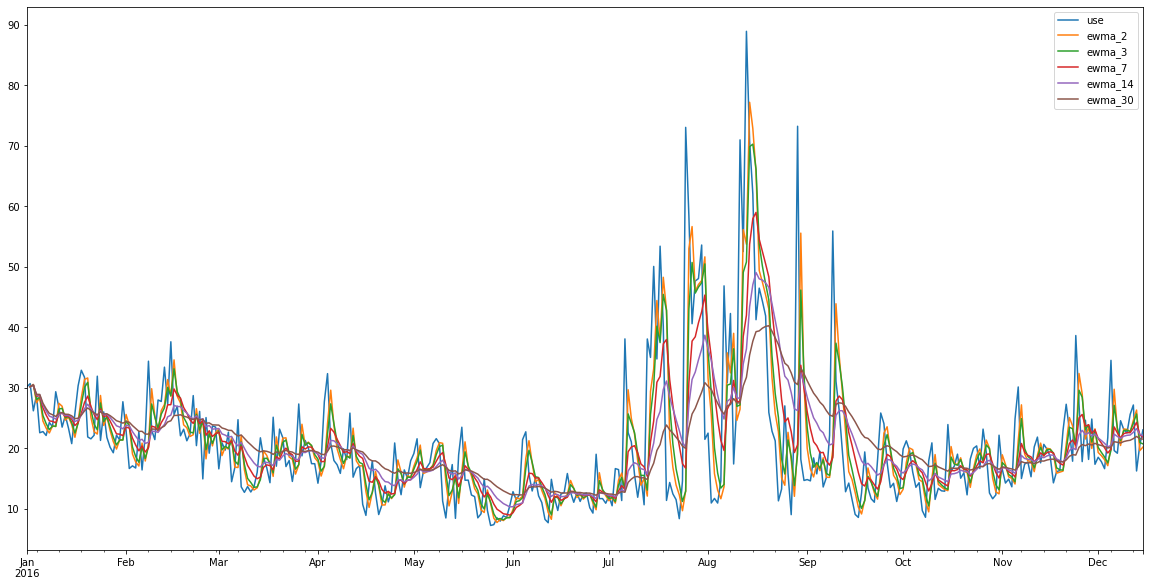

In [17]:
data_per_day[["use", "ewma_2", "ewma_3", "ewma_7", "ewma_14", "ewma_30"]].plot(figsize=(20,10))

<AxesSubplot:>

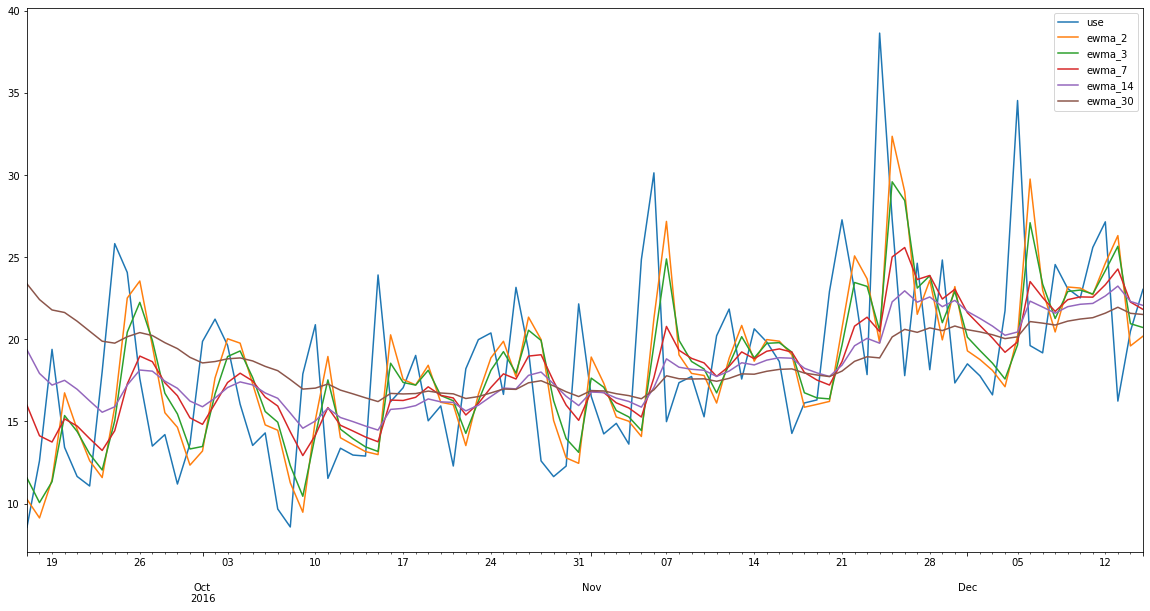

In [18]:
data_per_day.iloc[-90:][["use", "ewma_2", "ewma_3", "ewma_7", "ewma_14", "ewma_30"]].plot(figsize=(20, 10))

In [19]:
rmse_ewma_2 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_2"]]))
rmse_ewma_3 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_3"]]))
rmse_ewma_7 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_7"]]))
rmse_ewma_14 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_14"]]))
rmse_ewma_30 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_30"]]))

In [20]:
print("The RMSE of exponential weighted moving average of 2 span is : ", rmse_ewma_2)
print("The RMSE of exponential weighted moving average of 3 span is : ", rmse_ewma_3)
print("The RMSE of exponential weighted moving average of 7 span is : ", rmse_ewma_7)
print("The RMSE of exponential weighted moving average of 14 span is : ", rmse_ewma_14)
print("The RMSE of exponential weighted moving average of 30 span is : ", rmse_ewma_30)

The RMSE of exponential weighted moving average of 2 span is :  5.441997249193937
The RMSE of exponential weighted moving average of 3 span is :  5.274522789891057
The RMSE of exponential weighted moving average of 7 span is :  5.056483792898843
The RMSE of exponential weighted moving average of 14 span is :  5.030420078243165
The RMSE of exponential weighted moving average of 30 span is :  5.460184279506287


In [21]:
mape_ewma_2 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_2"]])
mape_ewma_3 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_3"]])
mape_ewma_7 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_7"]])
mape_ewma_14 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_14"]])
mape_ewma_30 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_30"]])

In [22]:
print("The MAPE of exponential weighted moving average of 2 span is : ", mape_ewma_2)
print("The MAPE of exponential weighted moving average of 3 span is : ", mape_ewma_3)
print("The MAPE of exponential weighted moving average of 7 span is : ", mape_ewma_7)
print("The MAPE of exponential weighted moving average of 14 span is : ", mape_ewma_14)
print("The MAPE of exponential weighted moving average of 30 span is : ", mape_ewma_30)

The MAPE of exponential weighted moving average of 2 span is :  0.22286483466893672
The MAPE of exponential weighted moving average of 3 span is :  0.22086365509640096
The MAPE of exponential weighted moving average of 7 span is :  0.21995233626526378
The MAPE of exponential weighted moving average of 14 span is :  0.22606955018620903
The MAPE of exponential weighted moving average of 30 span is :  0.2548911313219646


In [23]:
data_per_day["ewma_14"] 

2016-01-01          NaN
2016-01-02    30.169358
2016-01-03    30.443296
2016-01-04    28.817442
2016-01-05    28.817918
                ...    
2016-12-11    22.184701
2016-12-12    22.638872
2016-12-13    23.240451
2016-12-14    22.307192
2016-12-15    22.064481
Freq: D, Name: ewma_14, Length: 350, dtype: float64

In [24]:
type(data_per_day.ewma_14)

pandas.core.series.Series

In [25]:
# To select the history value from use column
data_per_day.use.loc["2016-09-01":"2016-09-14"]

2016-09-01    14.822851
2016-09-02    14.605787
2016-09-03    18.399837
2016-09-04    15.763038
2016-09-05    19.487802
2016-09-06    13.593951
2016-09-07    15.168214
2016-09-08    22.143996
2016-09-09    55.920509
2016-09-10    31.093064
2016-09-11    26.265614
2016-09-12    19.478169
2016-09-13    12.805151
2016-09-14    14.238505
Freq: D, Name: use, dtype: float64

In [26]:
# To select the forecast value from ewma_14 column
data_per_day.ewma_14.loc["2016-09-15"]

22.387701556885194

In [27]:
# If we want to save the result of ewma_14 into csv, can use the code below
#forecast_ewma14 = data_per_day.ewma_14.to_frame()
#forecast_ewma14.to_csv(r'Forest value ewma 14.csv')